In [1]:
from coosys import cartesian_to_kepler as ctk, cartesian_to_quaternion as ctq
from coosys import kepler_to_cartesian as ktc, quaternion_to_cartesian as qtc
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import PolynomialFeatures as PF
from scipy.interpolate import UnivariateSpline as US
from scipy import signal
import spectrum
from tqdm.auto import tqdm
tqdm.pandas()

from matplotlib import pyplot as plt
%matplotlib inline

D:\Anaconda3\envs\Standard\lib\site-packages\tqdm\std.py:654: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
base = 1.3885 * 10**9

train_data = pd.read_csv("IDAO 2020/train.csv", encoding="utf8")
train_data["epoch"] = pd.to_datetime(train_data["epoch"]).apply(pd.Timestamp.timestamp) - base

test_data = pd.read_csv("IDAO 2020/Track 1/test.csv", encoding="utf8")
test_data["epoch"] = pd.to_datetime(test_data["epoch"]).apply(pd.Timestamp.timestamp) - base

In [3]:
gamma_km = 398603

def transform_row(row, func):
    return func(row.values)

def transform_dataset(data, func=lambda data: ctk(data, gamma_km), 
                      columns_from=("x", "y", "z", "Vx", "Vy", "Vz"), 
                      columns_to=("a", "e", "inclination", "longitude", "argument", "anomaly")):
    new_data = data.loc[:, list(columns_from)].progress_apply(transform_row, axis=1, result_type="expand", args=(func, ))
    new_data.columns = columns_to
    return data.drop(list(columns_from), axis=1).join(new_data)

In [4]:
train_quaternion = transform_dataset(train_data, func=lambda data: ctq(data, gamma_km),
                                     columns_from=("x", "y", "z", "Vx", "Vy", "Vz"),
                                     columns_to=(("a", "e", "anomaly", "q1", "q2", "q3", "q4")))
train_quaternion = transform_dataset(train_quaternion, func=lambda data: ctq(data, gamma_km), 
                                     columns_from=("x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"),
                                     columns_to=("a_sim", "e_sim", "anomaly_sim", "q1_sim", "q2_sim", "q3_sim", "q4_sim"))

In [5]:
def phase_regression(phases):
    periods = 0
    new_phases = phases.copy()
    for i in range(1, phases.size):
        if phases[i] < phases[i - 1]:
            periods += 1
        new_phases[i] += 2 * np.pi * periods
    return new_phases

def phase_degression(phases):
    new_phases = np.zeros_like(phases)
    for i in range(phases.size):
        new_phases[i] = phases[i] - 2 * np.pi * np.trunc(phases[i] / 2 / np.pi) 
    return new_phases

In [6]:
def plot_coordinate(dataset, sat_id, coordinate, time_set=None, transform=lambda x: x,):
    sat_dataset = dataset[dataset.sat_id == sat_id].sort_values("epoch")
    coordinate_set = sat_dataset[coordinate].to_numpy()
    coordinate_sim_set = sat_dataset[coordinate + "_sim"].to_numpy()
    time = sat_dataset["epoch"].to_numpy()
    if time_set is None:
        time_set = (time.min(), time.max())
        
    mask = np.logical_and(time_set[0] <= time, time <= time_set[1])
    
    plt.xlabel("time")
    plt.ylabel(coordinate)
    plt.plot(time[mask], transform(coordinate_set)[mask])
    plt.plot(time[mask], transform(coordinate_sim_set)[mask])
    plt.legend(["true", "approximate"])
    plt.show()
    
    plt.xlabel("time")
    plt.ylabel(coordinate)
    plt.plot(time[mask], transform(coordinate_set)[mask])
    plt.legend(["true"])
    plt.show()
    
    plt.xlabel("time")
    plt.ylabel(coordinate)
    plt.plot(time[mask], transform(coordinate_sim_set)[mask])
    plt.legend(["approximate"])
    plt.show()
    
    plt.xlabel("time")
    plt.ylabel(coordinate)
    plt.plot(time[mask], (transform(coordinate_set) - transform(coordinate_sim_set))[mask])
    plt.legend(["difference"])
    plt.show()

Разность между истинным и приближенным значением аномалии осциллирует с почти постоянным периодом (в 2 пи по примерной аномалии) и переменной амплитудой (и средним значением). По большей части, для амплитуды (и среднего значения) можно выделить две основных зависимости: непрерывный почти линейный рост и редкие скачки. Основная проблема заключается в стохастической природе этих скачков и фазовых сдвигов, что иногда их сопровождают. Если не принимать во внимание эти сдвиги, нормализованные осцилляции примерно синусоидальны. 

In [7]:
def anomaly_analisys_plots(data, sat_id, periods=10, freq=100):
    sat_data = data[data.sat_id == sat_id]
    sat_data["fixed_anomaly"] = phase_regression(sat_data["anomaly"].to_numpy())
    sat_data["fixed_anomaly_sim"] = phase_regression(sat_data["anomaly_sim"].to_numpy())
    sat_data["fixed_anomaly_diff"] = sat_data["fixed_anomaly"] - sat_data["fixed_anomaly_sim"]
    
    plt.xlabel("anomaly")
    plt.ylabel("anomaly difference")
    plt.plot(sat_data["fixed_anomaly_sim"].to_numpy(), 
             sat_data["fixed_anomaly_diff"].to_numpy())
    
    maxs = signal.argrelmax(sat_data["fixed_anomaly_diff"].to_numpy())[0]
    mins = signal.argrelmin(sat_data["fixed_anomaly_diff"].to_numpy())[0]
    
    plt.plot(sat_data["fixed_anomaly_sim"].to_numpy()[maxs], sat_data["fixed_anomaly_diff"].to_numpy()[maxs])
    plt.plot(sat_data["fixed_anomaly_sim"].to_numpy()[mins], sat_data["fixed_anomaly_diff"].to_numpy()[mins])
    plt.legend(["true difference", "upper edge", "lower edge"])
    plt.show()
    
    maxs_spline = US(sat_data["fixed_anomaly_sim"].to_numpy()[maxs], sat_data["fixed_anomaly_diff"].to_numpy()[maxs], s=0, k=1)
    mins_spline = US(sat_data["fixed_anomaly_sim"].to_numpy()[mins], sat_data["fixed_anomaly_diff"].to_numpy()[mins], s=0, k=1)
    middle_spline = lambda x: (maxs_spline(x) + mins_spline(x)) / 2
    amplitude_spline = lambda x: maxs_spline(x) - mins_spline(x)
    
    sat_data["fixed_anomaly_oscillations"] = (sat_data["fixed_anomaly_diff"].to_numpy() - middle_spline(sat_data["fixed_anomaly_sim"].to_numpy())) / amplitude_spline(sat_data["fixed_anomaly_sim"].to_numpy())
    
    plt.xlabel("anomaly")
    plt.ylabel("anomaly normalized difference")
    plt.plot(sat_data["fixed_anomaly_sim"].to_numpy(), sat_data["fixed_anomaly_oscillations"].to_numpy())
    plt.legend(["oscillation"])
    plt.show()
    
    spline = US(sat_data["fixed_anomaly_sim"].to_numpy(), sat_data["fixed_anomaly_oscillations"].to_numpy(), s=0)
    
    specter = spectrum.parma(spline(2 * np.pi * np.linspace(0, periods, periods * freq)), 15, 15, 30, NFFT=100)
    specter.run()
    print("Main anomaly difference frequency: {} of period".format(specter.frequencies()[np.argmax(specter.psd)] * freq))
    specter.plot()

Пример почти линейного роста амплитуды, и явно выделенной основной частоты.

D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

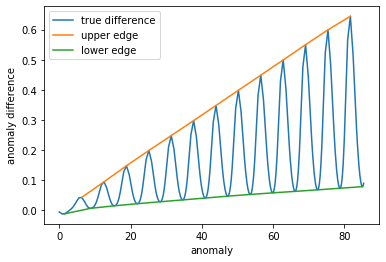

D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


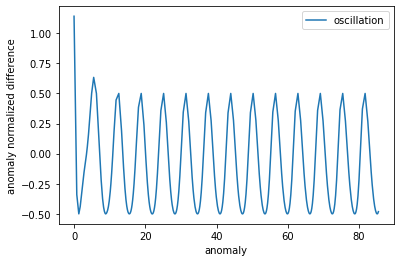

Main anomaly difference frequency: 1.0 of period


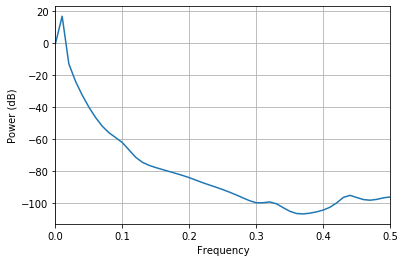

In [8]:
anomaly_analisys_plots(train_quaternion, 9)

Пример небольшого непрерывного роста с резкими скачками. В данном случае так же есть сдвиг по фазе, что мешает определить истинную частоту.

D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

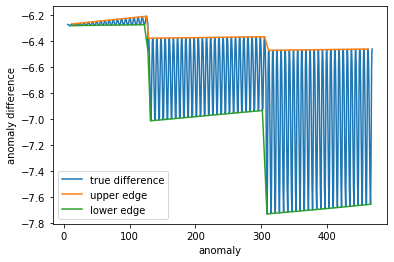

D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


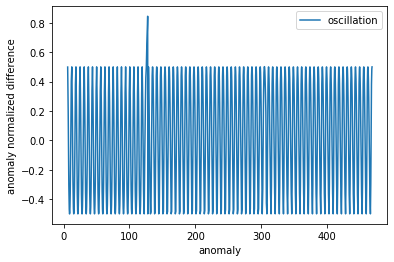

Main anomaly difference frequency: 0.0 of period


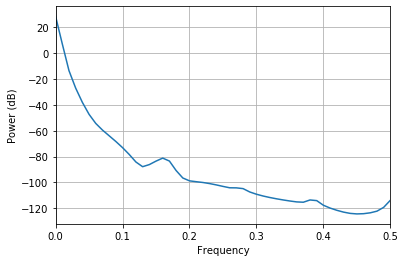

In [9]:
anomaly_analisys_plots(train_quaternion, 10)

Пример бредовой комбинации зависимостей.

D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

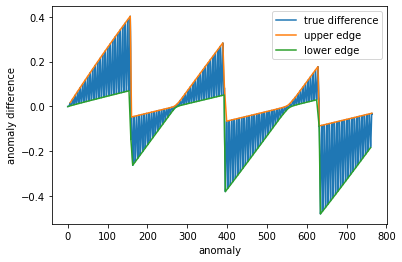

D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


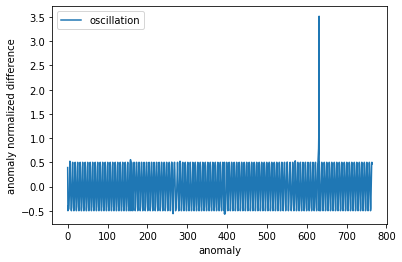

Main anomaly difference frequency: 1.0 of period


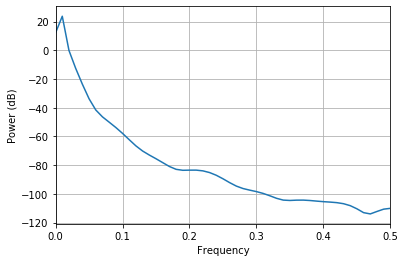

In [10]:
anomaly_analisys_plots(train_quaternion, 15)

Пример нелинейного роста амплитуды.

D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

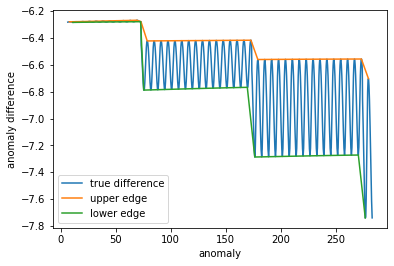

D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


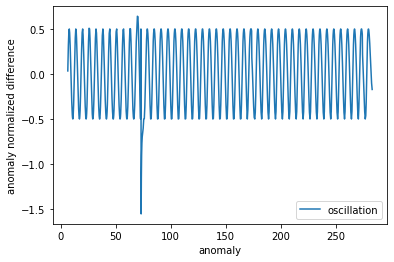

Main anomaly difference frequency: 0.0 of period


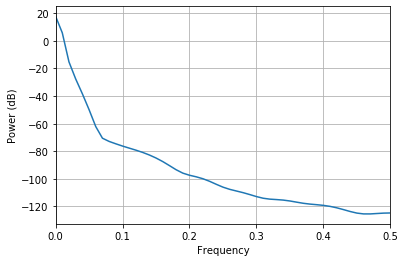

In [11]:
anomaly_analisys_plots(train_quaternion, 13)

Пример осцилляций с шумом.

D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

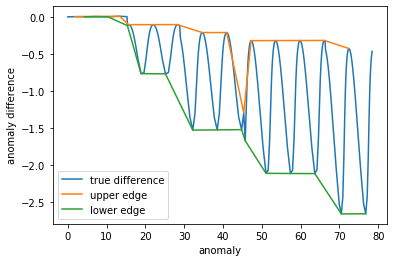

D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


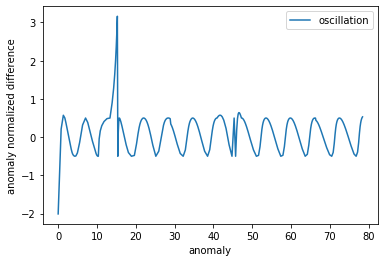

Main anomaly difference frequency: 1.0 of period


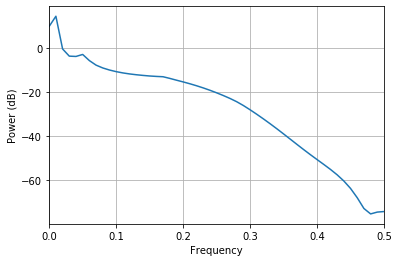

In [12]:
anomaly_analisys_plots(train_quaternion, 12)

Для разницы истинной и приближенной величины большей полуоси осцилляции по приближенной аномалии имеют сложную (несинусоидальную) форму и осциллирующую амплитуду (в виде биений либо модуляции) с редкими резкими скачками. Из-за этого внятное предсказание этих колебаний затруднительно, и спектральный анализ не дает полезных результатов. Впрочем, по локальным максимумам частоты можно попробовать восстановить осцилляции амплитуды.

In [13]:
def a_analisys_plots(data, sat_id, periods=10, freq=100):
    sat_data = data[data.sat_id == sat_id]
    sat_data["fixed_anomaly_sim"] = phase_regression(sat_data["anomaly_sim"].to_numpy())
    sat_data["a_diff"] = sat_data["a"] - sat_data["a_sim"]
    
    plt.xlabel("anomaly")
    plt.ylabel("a difference")
    plt.plot(sat_data["fixed_anomaly_sim"].to_numpy(), 
             sat_data["a_diff"].to_numpy())
    plt.legend(["true difference"])
    plt.show()
    
    spline = US(sat_data["fixed_anomaly_sim"].to_numpy(), sat_data["a_diff"].to_numpy(), s=0)
    
    specter = spectrum.parma(spline(2 * np.pi * np.linspace(0, periods, periods * freq)), 15, 15, 30, NFFT=100)
    specter.run()
    print("Main a difference frequency: {} of period".format(specter.frequencies()[np.argmax(specter.psd)] * freq))
    specter.plot()

Пример маловнятной зависимости: сложная форма, есть скачки.

D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


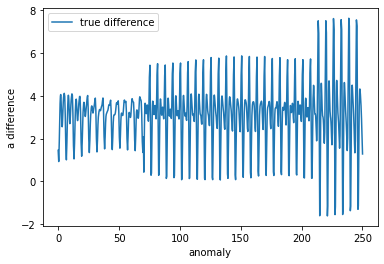

Main a difference frequency: 0.0 of period


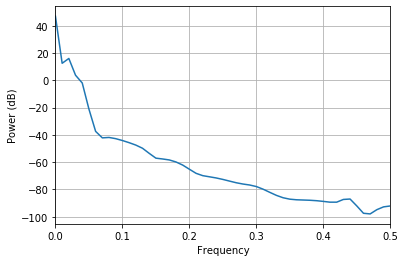

In [14]:
a_analisys_plots(train_quaternion, 0)

Пример модуляции.

D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


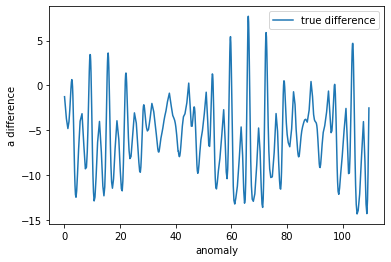

Main a difference frequency: 0.0 of period


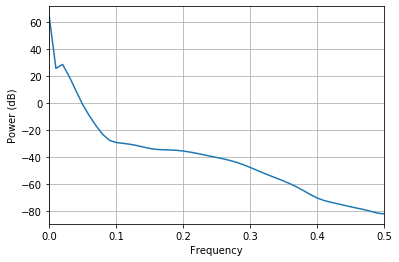

In [15]:
a_analisys_plots(train_quaternion, 2)

Пример биений.

D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\envs\Standard\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


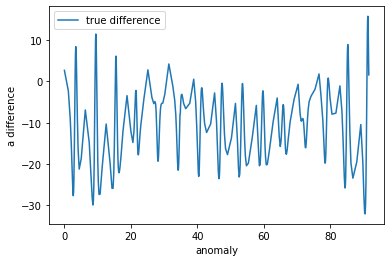

Main a difference frequency: 0.0 of period


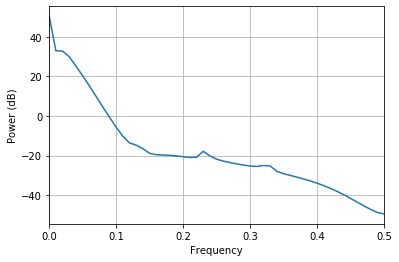

In [16]:
a_analisys_plots(train_quaternion, 3)